In [1]:
import os
import sys

import polars as pl
import numpy as np
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

In [2]:
# 約定履歴21日分を読み込む。あらかじめdownload_trades.pyを使ってデータファイルをダウンロードしておくこと。
days = 21
symbol = "BTCUSDT"

# 指定日から30日前までのデータを使いたい場合
last_date = date(year=2023, month=5, day=5)
# 昨日から30日前までのデータを使いたい場合
# last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

if "df_trades" in globals():
    del df_trades
df_trades = None
date_cursor = start_date

while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")
df_trades.describe()

In [3]:
# タイムバーを作成
groupby_interval_min = 30
groupby_interval = groupby_interval_min * 60 * 1000

df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("Open"), pl.col("price").max().alias("High"), pl.col("price").min().alias("Low"), pl.col("price").last().alias("Close"), np.abs(pl.col("qty")).sum().alias("Volume"), pl.col("qty").sum().alias("qty_sum"), (pl.col("price").std() / np.sqrt(60)).alias("real_sigma")])
df_timebar = df_timebar.with_columns([((pl.col("Close") - pl.col("Open")) / pl.col("Open")).alias("pct_change_price"), (pl.col("Close") - pl.col("Open")).alias("delta_price")])

# OK Estimatorを利用してボラティリティを推定
def OK_Estimator(open, high, low, close, duration_sec):
    return (0.811 * (high - low) - 0.369 * np.abs(close - open)) / np.sqrt(duration_sec)
df_timebar = df_timebar.with_columns([OK_Estimator(pl.col("Open"), pl.col("High"), pl.col("Low"), pl.col("Close"), groupby_interval / 1000).alias("estimated_sigma")])



argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: invalid value encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


_popt = [5.65702318e+01 5.86418838e-03]


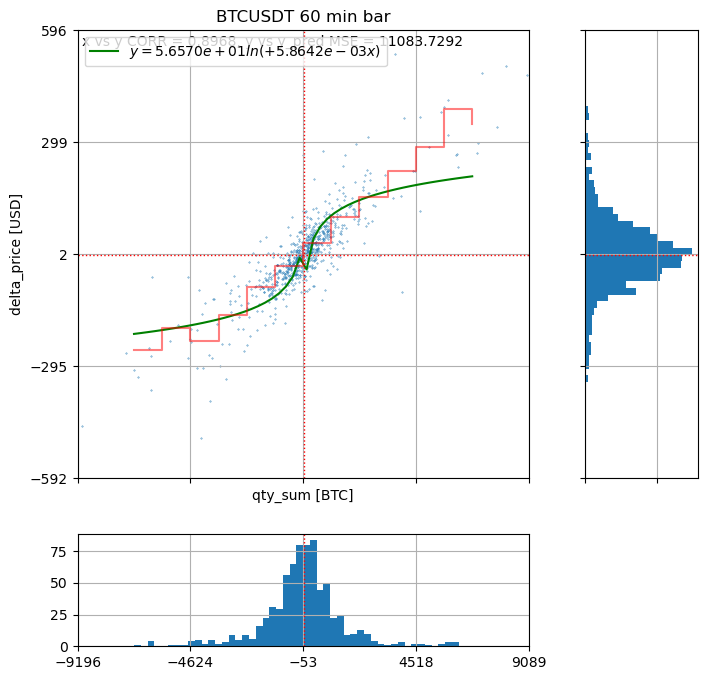

In [4]:
# タイムバーの売買インバランス対価格変化の散布図を作成し、後に使うパラメータb, cを計算する
# _popt[0]がb, _popt[1]がcに相当する
x = df_timebar["qty_sum"]
y = df_timebar["delta_price"]

def func(x, a, b):
    return np.where(np.abs(x) < 1, 0, np.sign(x) * a * np.log(b * np.abs(x)))
func_str = "$y = %s ln(%s x)$"

plot_correlation(x, y, func=func, func_label=func_str, title=f"{symbol} {groupby_interval_min} min bar", xaxis_label="qty_sum [BTC]", yaxis_label="delta_price [USD]", legend_loc="best")

_popt = [ 0.03679666 -0.08869999]


/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: overflow encountered in power
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: overflow encountered in multiply
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


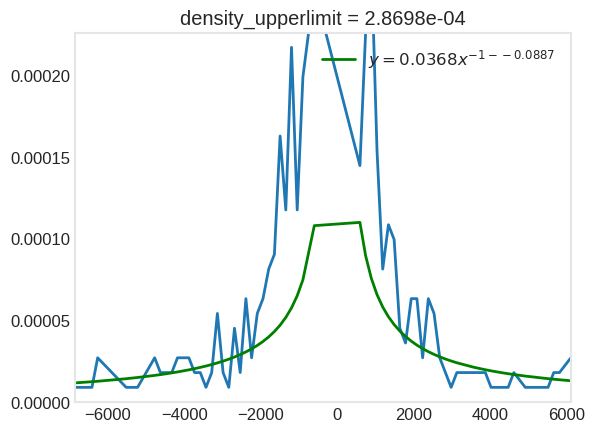

In [12]:
# タイムバーの売買インバランスの確率分布図を作成し、後に使うパラメータa, \alphaを計算する
# _popt[0]がa, _popt[1]が\alphaに相当する
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_quantile = 0.90
density_upperlimit = np.quantile(array_histogram[0], density_quantile)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)

def func(x, a, b):
    return a * np.power(np.abs(x), -1-b)
    
_popt, _pcov = curve_fit(func, df_histogram["qty_sum"], df_histogram["density"])
print(f"_popt = {_popt}")

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_upperlimit = np.quantile(array_histogram[0], 0.97)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)
plt.plot(df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], func(df_histogram["qty_sum"], *_popt), color = 'green', label = '$y = %s x^{-1 - %s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, df_histogram["density"].quantile(0.97))
plt.xlim(df_histogram["qty_sum"].quantile(0.1), df_histogram["qty_sum"].quantile(0.9))
plt.title(f"density_upperlimit = {density_upperlimit:.4e}")
plt.grid()
plt.legend()

$f^Q (x) = a\cdot x^{-1-\alpha}$

$$
a=0.3396702 \\
\alpha=0.14791845 \\
$$

$\Delta p = b\cdot\log(c\cdot Q)$

$$
b=11.11420511\\
c=0.05961304
$$

$\Lambda = \frac{1}{15 \cdot 60}$ (15分を基準時間とするため)

$$
\begin{aligned}
\lambda(\delta) &= \Lambda\cdot P(\Delta p > \delta)\\
&= \Lambda\cdot P(b\cdot\ln(c\cdot Q) > \delta)\\
&= \Lambda\cdot P\left(c\cdot Q > \exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda\cdot P\left(Q > \frac{1}{c}\exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda \int_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty} a\cdot x^{-1-\alpha} dx\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[x^{-\alpha}\right]_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty}\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[0 - \frac{1}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\right]\\
&= \frac{\Lambda}{\alpha}\cdot\frac{a}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\\
&= A\cdot\exp\left(-k\cdot\delta\right)\\
\end{aligned}
$$

In [6]:
# 各種定数
Lambda = 1 / (15 * 60)
a, alpha = [226.98638124, 1.1254549]
b, c = [3.0534806e+01, 1.2302710e-02]

# 定数から A exp(-k \delta)で利用するパラメータを計算
A = Lambda / alpha * a / c
k = alpha / b

gamma = 1
xi = gamma
delta = 1

def delta_b_delta_a(k, q, delta, sigma, A, gamma):
    return 2 / k + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2 * np.e) / (2 * A * delta * k))
    
def delta_b_delta_a_with_xi(k, q, delta, sigma, A, gamma):
    return 2 / (xi * delta) * np.log(1 + (xi * delta) / k) + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2) / (2 * A * delta * k) * np.power((1 + (xi * delta) / k), k / (xi * delta) + 1))

df_timebar = df_timebar.with_columns((delta_b_delta_a_with_xi(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a_xi")))
df_timebar = df_timebar.with_columns((delta_b_delta_a(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a"))).drop_nulls()
df_timebar

timestamp,Open,High,Low,Close,Volume,qty_sum,real_sigma,pct_change_price,delta_price,estimated_sigma,delta_b_delta_a_xi,delta_b_delta_a
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1680656400000,28655.7,28743.1,28537.4,28560.0,32093.853,95.165,4.912558,-0.00334,-95.7,2.191823,1709.93685,552.146714
1680660000000,28560.0,28800.0,28507.5,28558.4,24043.608,1378.434,8.199497,-0.000056,-1.6,3.943785,646.793833,241.377057
1680663600000,28558.5,28573.0,28422.6,28536.1,15261.49,495.092,4.330264,-0.000784,-22.4,1.895147,1158.452702,390.941178
1680667200000,28536.1,28572.9,28468.0,28496.1,10961.535,-288.377,3.070729,-0.001402,-40.0,1.171898,560.149673,216.049914
1680670800000,28496.1,28615.0,28466.0,28571.7,10622.87,776.194,4.265579,0.002653,75.6,1.549043,348.925631,154.306553
1680674400000,28571.6,28591.4,28477.0,28520.0,7718.91,-1125.408,3.69002,-0.001806,-51.6,1.228967,459.070498,186.503239
1680678000000,28520.0,28529.8,28433.4,28515.7,8898.691,-974.797,2.892423,-0.000151,-4.3,1.276562,365.592388,159.178449
1680681600000,28515.7,28593.0,28432.4,28530.0,13295.789,485.603,5.393153,0.000501,14.3,2.082832,379.492466,163.241611
1680685200000,28530.1,28588.1,28489.0,28498.9,7979.972,-9.626,3.26664,-0.001094,-31.2,1.147622,614.962912,232.072491


OK Volatility Estimatorを使ってバーのボラティリティを推定する。

$$
\frac{0.811 (\text{High} - \text{Low}) - 0.369 |\text{Close} - \text{Open}|}{\sqrt{\text{Duration of the Trading Sessoion}}}
$$

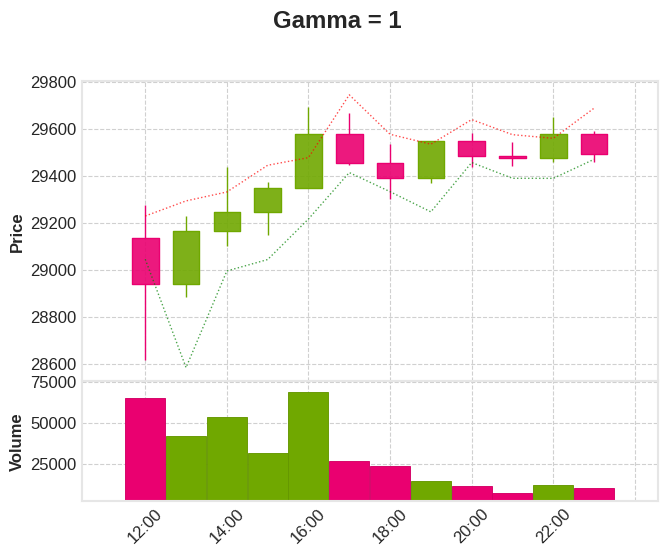

In [7]:
import pandas as pd
import mplfinance as mpf

df_timebar_pd = df_timebar.to_pandas()
df_timebar_pd["timestamp"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.set_index("timestamp")
df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index >= "2023-5-05 12:00:00") & (df_timebar_pd.index <= "2023-5-06")]

apdict = [
    mpf.make_addplot(df_timebar_pd_filtered["Open"] + df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='red', linestyle=':', width=1, alpha=0.7),
    mpf.make_addplot(df_timebar_pd_filtered["Open"] - df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='green', linestyle=':', width=1, alpha=0.7)]

mpf.plot(df_timebar_pd_filtered, type='candle', addplot=apdict, volume=True, style='binance', figscale=1.0, figsize=(8, 6), title=f"Gamma = {gamma}")
plt.show()

In [8]:
plt.plot(df_timebar["timestamp"], df_timebar["open"], label="open")
plt.plot(df_timebar["timestamp"], df_timebar["close"], label="close")
plt.plot(df_timebar["timestamp"], df_timebar["open"] + df_timebar["delta_b_delta_a"] / 2, label="ask")
plt.plot(df_timebar["timestamp"], df_timebar["open"] - df_timebar["delta_b_delta_a"] / 2, label="bid")
plt.xlim(1678406400000, 1678406400000 + 15 * 60 * 1000 * 10)
plt.ylim(19500, 20500)
plt.legend()

ColumnNotFoundError: open